# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [4]:
#trying to shift these 1h backwards
hour_cols = [
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]


## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))


A: 
 136245
Int64Index([118668], dtype='int64')
136244


Same problem for B-set at `2022-05-02 21:00:00` and C-set at `2022-04-25 21:00:00`

In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


In [7]:
# for col in hour_cols:
#     XTRA[col].shift(-4)
#     XTRB[col].shift(-4)
#     XTRB[col].shift(-4)


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

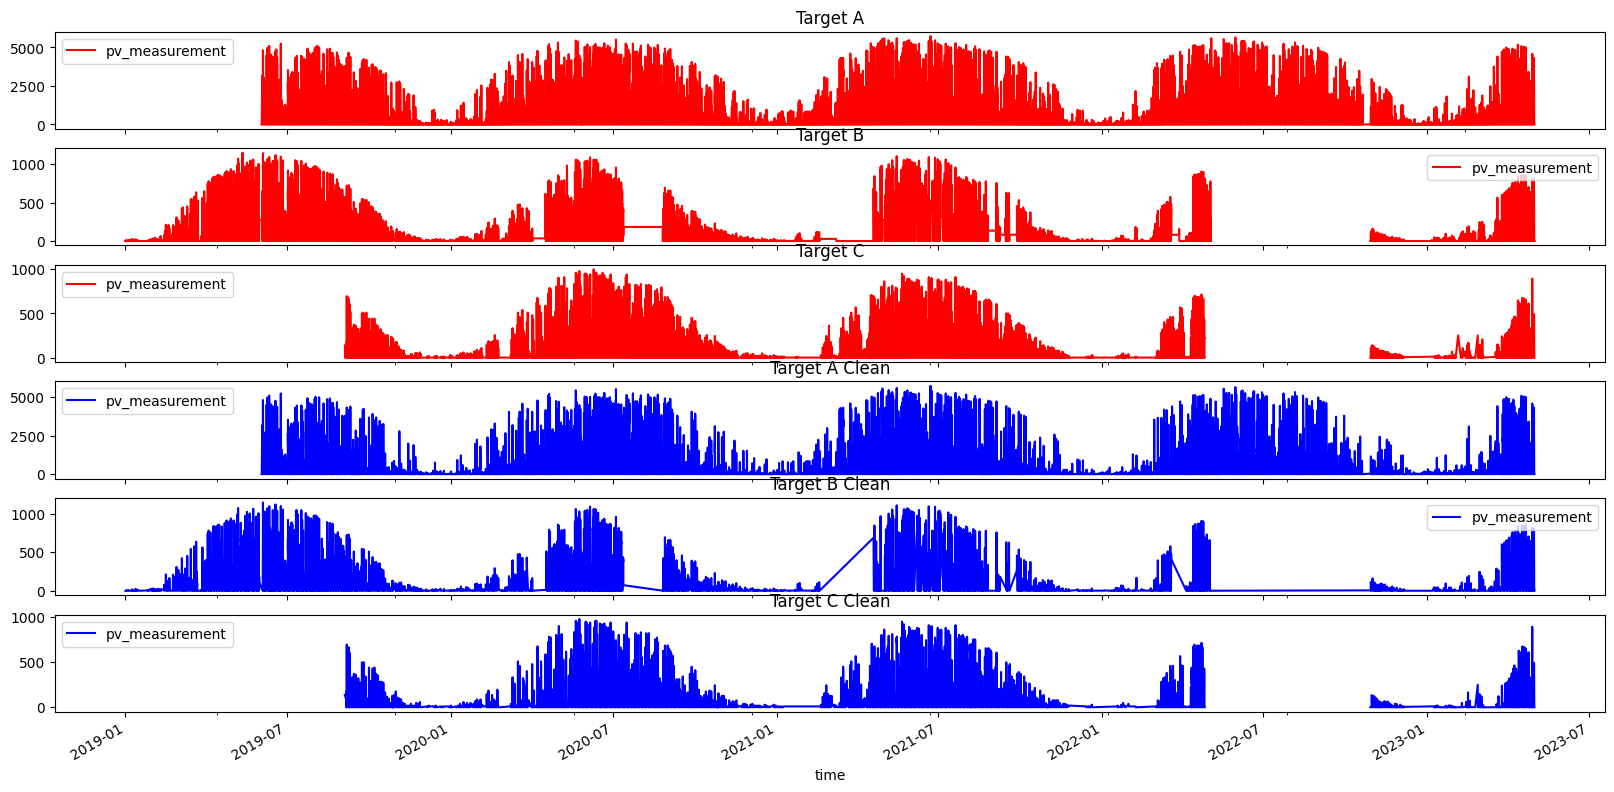

In [8]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
                zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [9]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [10]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  18071 18071
x,y:  12443 12443
x,y:  10129 10129


In [11]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())


18066   2023-04-30 19:00:00
18067   2023-04-30 20:00:00
18068   2023-04-30 21:00:00
18069   2023-04-30 22:00:00
18070   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
12438   2023-04-30 19:00:00
12439   2023-04-30 20:00:00
12440   2023-04-30 21:00:00
12441   2023-04-30 22:00:00
12442   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
10124   2023-04-30 19:00:00
10125   2023-04-30 20:00:00
10126   2023-04-30 21:00:00
10127   2023-04-30 22:00:00
10128   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]


# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), axis=0, ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i]['above_298_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_frames_test[i]['above_298_kelvin'] = np.where(X_frames_test[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
     X_frames_test[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True) # Negligable??
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


Combine features

In [13]:
def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
    X_train[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])
    X_frames_test[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])


Multiply Cloud_coverage's flipped values with clear_sky_energy

In [14]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_rad:W']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_rad:W']

    X_train[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])


In [15]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test[i].drop(columns=['air_density_2m:kgm3'], inplace=True)


In [16]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['ceiling_height_agl:m'].max())
    print(i, X_train[i]['ceiling_height_agl:m'].max())


0 11430.775
0 12005.6
1 11430.9
1 12005.7
2 11468.0
2 11982.6


Flipping this as well and replacing null with 0 might give better result. For instance null = no cluds, and by flipping the values we say that taller clouds are closer to no clouds than lower clouds. As in the real world. Simply using the highest measured ceiling height as flipping value and adding 1000 to differentiate from no clouds 

> (e.g. 100 gets flipped to 100-(max_height+1000))

In [17]:
X_train[i]['ceiling_height_agl:m'].tail(20)


10109    4022.100342
10110    4189.450195
10111    4583.450195
10112    4099.325195
10113    2434.050049
10114    1396.125000
10115    1260.025024
10116    1854.625000
10117    2856.574951
10118    3968.550049
10119    4919.075195
10120    4533.200195
10121    3356.399902
10122    2030.000000
10123    1943.750000
10124    1456.574951
10125    1476.349976
10126    1516.300049
10127    1240.599976
10128    1484.500000
Name: ceiling_height_agl:m, dtype: float32

In [18]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train)):
    X_frames_test[i]['ceiling_height_agl:m'] = X_frames_test[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train[i]['ceiling_height_agl:m']= X_train[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)


In [19]:
X_train[i]['ceiling_height_agl:m'].isna().sum()


2289

In [20]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['cloud_base_agl:m'].max())
    print(i, X_train[i]['cloud_base_agl:m'].max())


0 11256.7
0 11387.599
1 11256.8
1 11170.0
2 11467.8
2 11125.0


In [21]:
X_train[i]['cloud_base_agl:m'].tail(20)


10109     806.500000
10110     956.349976
10111    1151.574951
10112    1044.550049
10113     715.775024
10114     630.724976
10115     496.049988
10116     325.625000
10117     428.025024
10118     617.549988
10119     689.174988
10120     716.650024
10121     693.300049
10122     620.349976
10123     568.099976
10124     551.224976
10125     564.099976
10126     578.700012
10127     551.500000
10128     558.674988
Name: cloud_base_agl:m, dtype: float32

In [22]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train)):
    X_frames_test[i]['cloud_base_agl:m'] = X_frames_test[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train[i]['cloud_base_agl:m']= X_train[i]['cloud_base_agl:m'].apply(flip_ceiling_height)


In [23]:
X_train[i]['cloud_base_agl:m'].isna().sum()


873

In [24]:
print(X_frames_test[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'ceiling_height_agl:m',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa',
       'precip_5min:mm', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_d

## Data Cleaning

In [25]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,3525,2104,2289
cloud_base_agl:m,1322,910,873
snow_density:kgm3,17719,12166,10116


In [26]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [27]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


# Normalizing Y and merging all X and normalized Y

In [28]:
from data_func.combine_all_frames import combine_all_frames
from data_func.combine_series import combine_series


In [29]:
X_comb = combine_all_frames(X_train)


In [30]:
NYA=(Y_train[0]-Y_train[0].mean())/Y_train[0].std()
NYB=(Y_train[1]-Y_train[1].mean())/Y_train[1].std()
NYC=(Y_train[2]-Y_train[2].mean())/Y_train[2].std()


Verifying we can get back to original

In [31]:
print(NYA.head(), Y_train[0].head())


0   -0.666864
1   -0.666864
2   -0.666864
3   -0.666864
4   -0.652230
Name: pv_measurement, dtype: float64 0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64


In [32]:
NoYA = (NYA * Y_train[0].std())+Y_train[0].mean()
NoYA.head()


0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64

In [33]:
Y_comb = combine_series([NYA, NYB, NYC])


In [34]:
len(Y_comb)


40643

In [35]:
Y_comb.reset_index(drop=True, inplace=True)
Y_comb.tail()


40638   -0.433639
40639   -0.664875
40640   -0.679032
40641   -0.679032
40642   -0.679032
Name: pv_measurement, dtype: float64

# Training the model

In [36]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_comb, Y_comb, test_size=0.17, random_state=42)


In [37]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined_a = pd.merge(x_train_a, y_train_a, left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, presets='medium_quality', time_limit=900) #, presets='good_quality', time_limit=3600)


/Users/hansstem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20231111_123100/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20231111_123100/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   352.78 GB / 494.38 GB (71.4%)
Train Data Rows:    33733
Train Data Columns: 59
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique labe

[1000]	valid_set's l1: 0.147764
[2000]	valid_set's l1: 0.137948
[3000]	valid_set's l1: 0.132477
[4000]	valid_set's l1: 0.12929
[5000]	valid_set's l1: 0.126804
[6000]	valid_set's l1: 0.125135
[7000]	valid_set's l1: 0.123694
[8000]	valid_set's l1: 0.122526
[9000]	valid_set's l1: 0.121274
[10000]	valid_set's l1: 0.120432


	-0.1204	 = Validation score   (-mean_absolute_error)
	34.42s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 864.05s of the 864.04s of remaining time.


[1000]	valid_set's l1: 0.134385
[2000]	valid_set's l1: 0.125322
[3000]	valid_set's l1: 0.121918
[4000]	valid_set's l1: 0.119763
[5000]	valid_set's l1: 0.118392
[6000]	valid_set's l1: 0.117575
[7000]	valid_set's l1: 0.117013
[8000]	valid_set's l1: 0.116582
[9000]	valid_set's l1: 0.116399
[10000]	valid_set's l1: 0.116193


	-0.1162	 = Validation score   (-mean_absolute_error)
	32.85s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 830.61s of the 830.61s of remaining time.
	-0.1507	 = Validation score   (-mean_absolute_error)
	30.73s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 799.58s of the 799.57s of remaining time.
	-0.1262	 = Validation score   (-mean_absolute_error)
	73.56s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 725.99s of the 725.99s of remaining time.
	-0.148	 = Validation score   (-mean_absolute_error)
	5.99s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 719.71s of the 719.71s of remaining time.
	-0.16	 = Validation score   (-mean_absolute_error)
	13.96s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training mode

[1000]	valid_set's l1: 0.120322
[2000]	valid_set's l1: 0.115154
[3000]	valid_set's l1: 0.11362
[4000]	valid_set's l1: 0.113039
[5000]	valid_set's l1: 0.112777
[6000]	valid_set's l1: 0.112624
[7000]	valid_set's l1: 0.112563
[8000]	valid_set's l1: 0.112528
[9000]	valid_set's l1: 0.112508
[10000]	valid_set's l1: 0.112497


	-0.1125	 = Validation score   (-mean_absolute_error)
	126.46s	 = Training   runtime
	0.8s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 528.59s of remaining time.
	-0.1112	 = Validation score   (-mean_absolute_error)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 371.52s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231111_123100/")


In [38]:
y_a_test = predictor.predict(x_val_a)


In [39]:
join_val_a = pd.merge(x_val_a, y_val_a, left_index=True, right_index=True)
predictor.leaderboard(join_val_a, silent=True)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.115538,-0.111188,4.525820,1.481524,193.823187,0.009590,0.000155,0.091249,2,True,12
1,LightGBMLarge,-0.117715,-0.112496,2.544964,0.804322,126.462543,2.544964,0.804322,126.462543,1,True,11
2,LightGBM,-0.120197,-0.116191,0.977319,0.329937,32.851330,0.977319,0.329937,32.851330,1,True,4
3,LightGBMXT,-0.122348,-0.120427,0.993948,0.347110,34.418065,0.993948,0.347110,34.418065,1,True,3
4,XGBoost,-0.128340,-0.125684,0.438065,0.133108,35.590024,0.438065,0.133108,35.590024,1,True,9
5,CatBoost,-0.128956,-0.126185,0.040837,0.007528,73.564404,0.040837,0.007528,73.564404,1,True,6
6,ExtraTreesMSE,-0.152954,-0.147965,0.271417,0.051704,5.989104,0.271417,0.051704,5.989104,1,True,7
7,RandomForestMSE,-0.154959,-0.150696,0.329467,0.063916,30.729509,0.329467,0.063916,30.729509,1,True,5
8,NeuralNetFastAI,-0.162843,-0.160029,0.056188,0.012518,13.964507,0.056188,0.012518,13.964507,1,True,8
9,NeuralNetTorch,-0.176680,-0.169957,0.029510,0.013605,13.148264,0.029510,0.013605,13.148264,1,True,10


In [40]:
joined_c = pd.merge(X_comb, Y_comb, left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, presets='medium_quality', time_limit=900)#, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231111_123722/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20231111_123722/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   351.53 GB / 494.38 GB (71.1%)
Train Data Rows:    40643
Train Data Columns: 59
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (4.04006112468314, -0.6790323058350966, -0.0, 0.99998)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify prob

[1000]	valid_set's l1: 0.151247
[2000]	valid_set's l1: 0.140646
[3000]	valid_set's l1: 0.134812
[4000]	valid_set's l1: 0.130657
[5000]	valid_set's l1: 0.128214
[6000]	valid_set's l1: 0.126178
[7000]	valid_set's l1: 0.124474
[8000]	valid_set's l1: 0.12303
[9000]	valid_set's l1: 0.121615
[10000]	valid_set's l1: 0.120782


	-0.1208	 = Validation score   (-mean_absolute_error)
	36.39s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 862.61s of the 862.61s of remaining time.


[1000]	valid_set's l1: 0.137325
[2000]	valid_set's l1: 0.128146
[3000]	valid_set's l1: 0.123558
[4000]	valid_set's l1: 0.121187
[5000]	valid_set's l1: 0.119782
[6000]	valid_set's l1: 0.118467
[7000]	valid_set's l1: 0.11767
[8000]	valid_set's l1: 0.117008
[9000]	valid_set's l1: 0.116546
[10000]	valid_set's l1: 0.116209


	-0.1162	 = Validation score   (-mean_absolute_error)
	34.83s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 827.2s of the 827.2s of remaining time.
	-0.148	 = Validation score   (-mean_absolute_error)
	38.29s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 788.61s of the 788.61s of remaining time.
	-0.1255	 = Validation score   (-mean_absolute_error)
	76.65s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 711.94s of the 711.94s of remaining time.
	-0.1441	 = Validation score   (-mean_absolute_error)
	7.19s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 704.5s of the 704.5s of remaining time.
	-0.1631	 = Validation score   (-mean_absolute_error)
	16.12s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model 

[1000]	valid_set's l1: 0.122362
[2000]	valid_set's l1: 0.115756
[3000]	valid_set's l1: 0.113604
[4000]	valid_set's l1: 0.112594
[5000]	valid_set's l1: 0.112181
[6000]	valid_set's l1: 0.111994
[7000]	valid_set's l1: 0.111882
[8000]	valid_set's l1: 0.111817
[9000]	valid_set's l1: 0.111783
[10000]	valid_set's l1: 0.111758


	-0.1118	 = Validation score   (-mean_absolute_error)
	132.69s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 495.94s of remaining time.
	-0.1108	 = Validation score   (-mean_absolute_error)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 404.17s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231111_123722/")


## Evaluate

In [41]:
a_ind = x_val_a[x_val_a['location'] == 0].index
b_ind = x_val_a[x_val_a['location'] == 1].index
c_ind = x_val_a[x_val_a['location'] == 2].index


In [42]:
pred = predictor.predict(x_val_a)


In [43]:
pred.head()


9291     1.237034
2020    -0.665758
39509   -0.318048
14658   -0.204442
36427   -0.086280
Name: pv_measurement, dtype: float32

In [44]:
len(a_ind)


3048

In [45]:
len(y_val_a[a_ind])


3048

In [46]:
from sklearn.metrics import mean_absolute_error

def upscale(val, location: int):
    return (val * Y_train[location].std())+Y_train[location].mean()



#Up_y_val_A = upscale(y_val_a[a_ind], 0)
#Up_y_val_B = upscale(y_val_a[b_ind], 1)
#Up_y_val_C = upscale(y_val_a[c_ind], 2)

mae_a = mean_absolute_error(upscale(y_val_a[a_ind], 0), upscale(pred[a_ind], 0))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(upscale(y_val_a[b_ind], 1), upscale(pred[b_ind], 1))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(upscale(y_val_a[c_ind], 2), upscale(pred[c_ind], 2))
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)


MAE for A:  167.64653255232363
MAE for B:  24.64656166508567
MAE for C:  24.20373496684346
Mean MAE:  72.16560972808425


In [47]:
# x_val_a


In [48]:
full_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
full_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
full_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)


In [49]:
pred = predictor.predict(X_train[0][34000:34025])


In [50]:
goal = Y_train[0][34000:34025]


In [54]:
#predictions before full training
x_test_comb = combine_all_frames(X_frames_test)
pred_test = predictor_c.predict(x_test_comb)
a_ind_test = x_test_comb[x_test_comb['location'] == 0].index
b_ind_test = x_test_comb[x_test_comb['location'] == 1].index
c_ind_test = x_test_comb[x_test_comb['location'] == 2].index
pred_a = upscale(pred_test[a_ind_test], 0)
pred_b = upscale(pred_test[b_ind_test], 1)
pred_c = upscale(pred_test[c_ind_test], 2)


# Make predictions

In [55]:
# Do some more stuff
y_pred = np.concatenate((pred_a, pred_b, pred_c), axis=0)

print(len(y_pred))


2160


In [56]:
y_pred[0:10]


array([  -9.422302,  -10.742798,   -5.270935,   69.862976,  307.9768  ,
        843.9812  , 1900.9215  , 2864.1719  , 3119.2007  , 2271.4226  ],
      dtype=float32)

In [57]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0


# Evaluate prediction

# Create submission

In [58]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/autogluon_med_300_full_submission.csv', index=False)


(2160,)
(2160,)


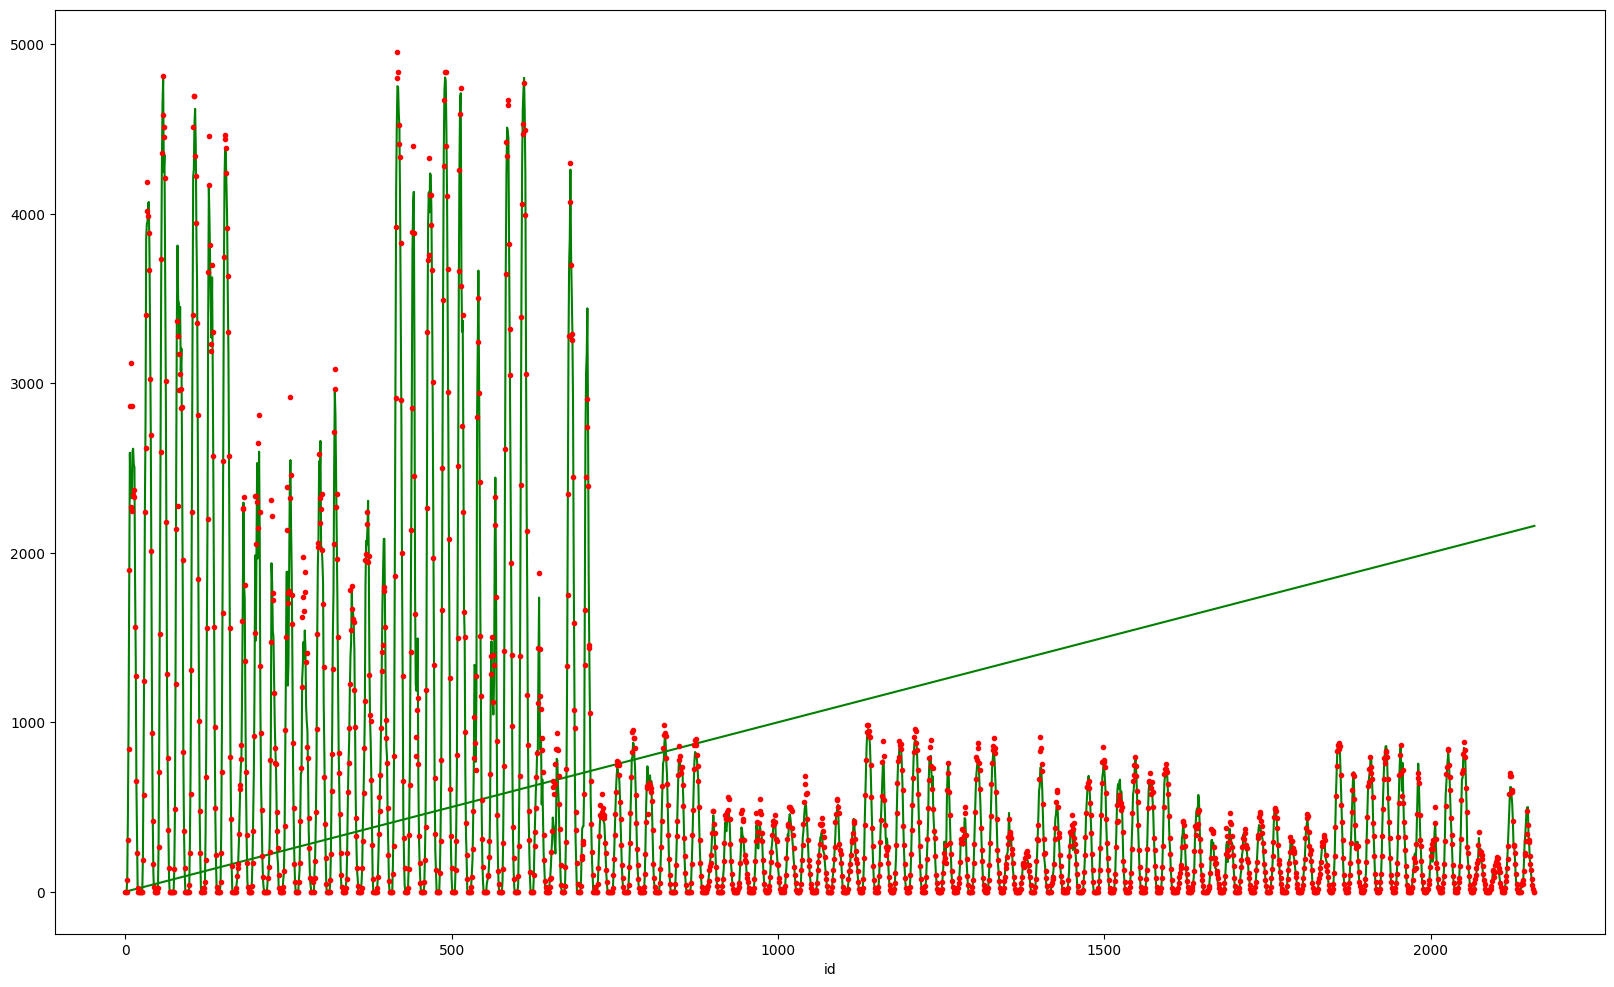

In [62]:
second_best_sub = pd.read_csv('./submissions/submission_cat_147SUI.csv')
best_submission = pd.read_csv('./submissions/autogluon_med_300_full_submission.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub, 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.xlabel("id")
plt.show()


120.27171717351307


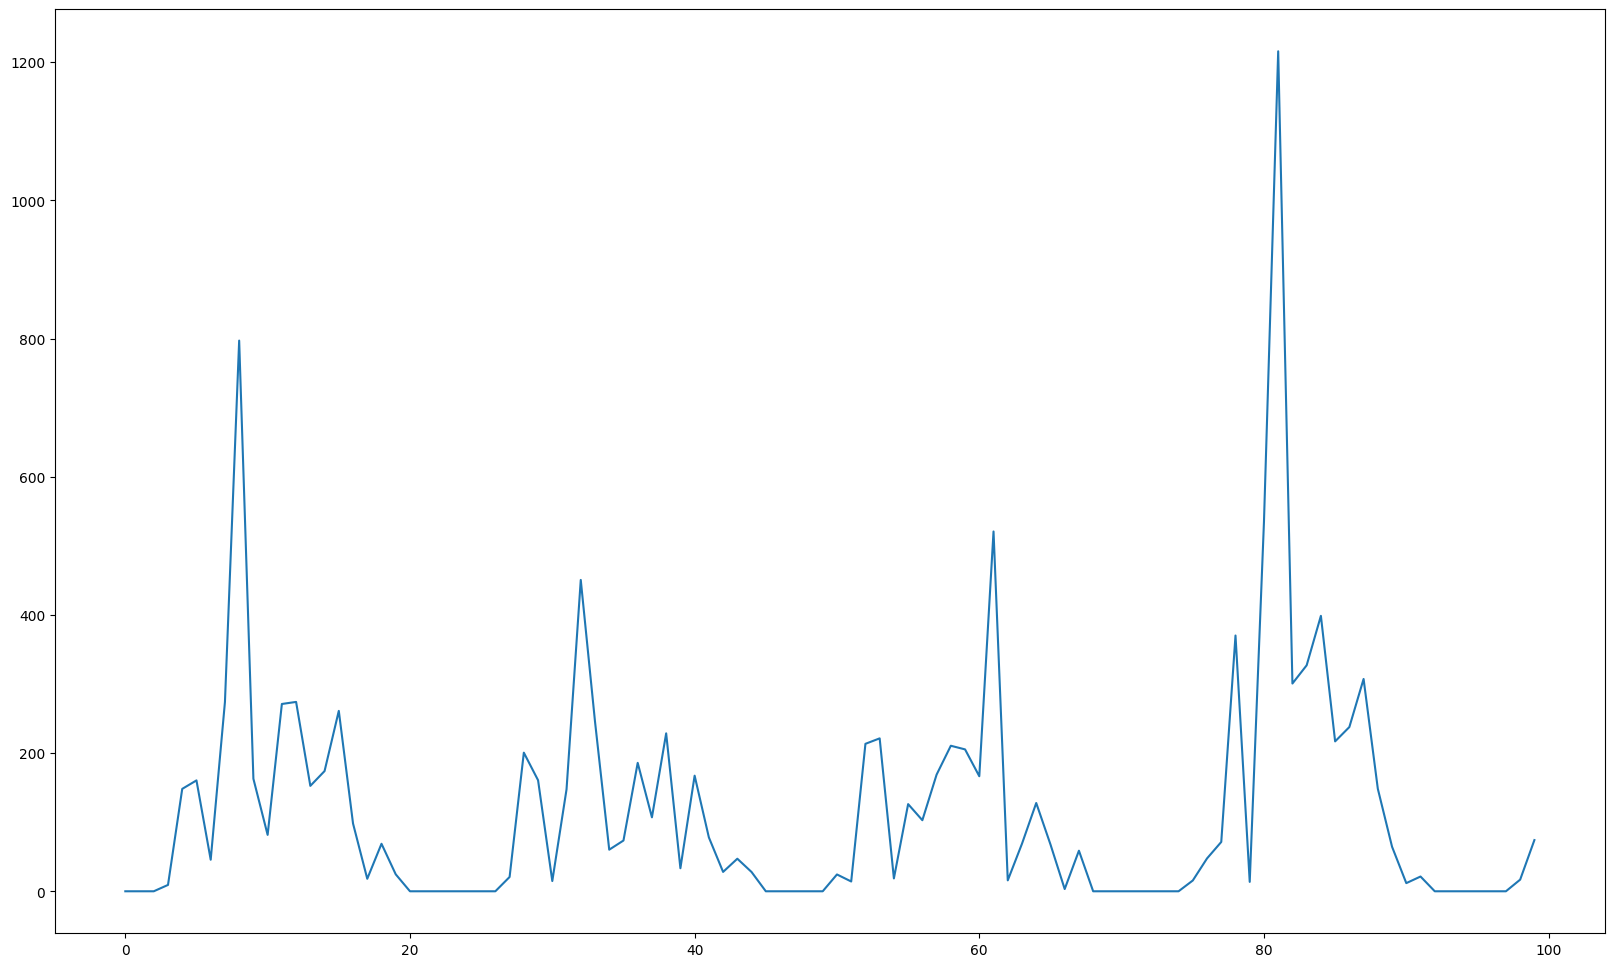

In [66]:
dist = abs(best_submission['prediction'][0:100] - second_best_sub['prediction'][0:100])
print(dist.mean())

plt.figure(figsize=(20,12))
plt.plot(dist)
